In [6]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

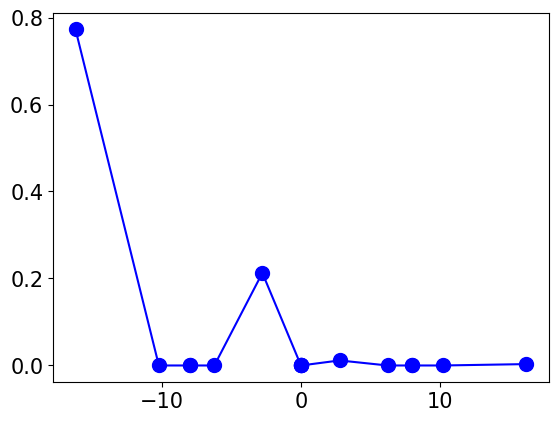

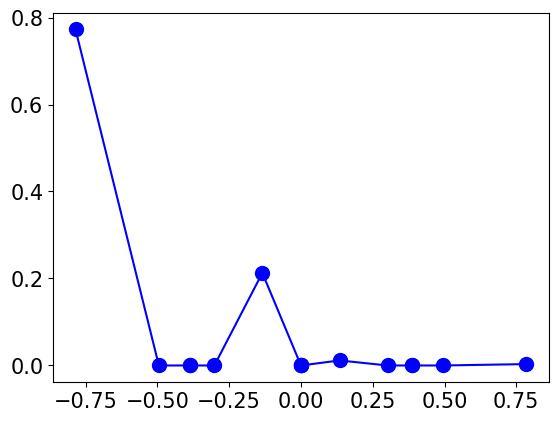

In [7]:
from scipy.linalg import norm
from scipy.linalg import expm
from numpy.linalg import eigh
from scipy.linalg import eigh

def modify_spectrum(ham):
    arr_ham = ham.toarray()
    arr_ham = arr_ham.astype(np.complex128)
    n = len(arr_ham[0])
    eigenenergies, eigenstates = ham.eigh(subset_by_index = (n-1,n-1))
    max_eigenvalue = eigenenergies[0]
    norm_ham = (np.pi/4)*arr_ham/max_eigenvalue
    # rotate matrix so that it will be positive definite
    # ham += 1/2*np.eye(2**eigen_bits)
    
    # convert revolutions to radians
    # norm_ham *= 2*np.pi*1j
    
    # convert the rotations to complex numbers
    # norm_ham = expm(norm_ham)
    return norm_ham

num_sites = 4
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()

# create modified spectrum
ham = modify_spectrum(ham)
eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [8]:
p0_array            = np.array([0.6,0.8]) # initial overlap with the first eigenvector
T0                  = 100
N_test_QCELS        = 10 # number of different circuit depths for QCELS test
N_QPE               = 10 # number of different circuit depths for QCELS QPE test
T_list_QCELS        = 10+T0/2*(np.arange(N_test_QCELS)) # circuit depth for QCELS
T_list_QPE          = 10+T0*4*(np.arange(N_QPE)) # circuit depth for QPE
err_QCELS           = np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE             = np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE   = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS  = np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE    = np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS         = np.zeros((len(p0_array),len(T_list_QCELS)))
Navg                = 1 # number of trials
err_thres_hold      = 0.01
err_thres_hold_QPE  = 0.01  

In [11]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_largeoverlap(spectrum, population, T, NT,
                            Nsample, lambda_prior)#QCELS with time T
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        print("N_try_QPE", N_try_QPE)
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
            print("discrete_energies", len(discrete_energies))
            print("T", T)
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            print("dist", dist.shape[0])
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE) # uses dist with counts to get samp
            print("samp", samp)
            j_min = samp.min()
            print("j_min", j_min)
            ground_energy_estimate_QPE = discrete_energies[j_min]
            print("ground_energy_estimate_QPE", ground_energy_estimate_QPE)
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Lin_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Lin_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Lin_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS
Re:  1.0 Im:  0.46
		 (1-0.07999999999999996j)
Re:  0.93 Im:  0.74
		 (0.8600000000000001+0.48j)
Re:  0.67 Im:  0.91
		 (0.3400000000000001+0.8200000000000001j)
Re:  0.56 Im:  0.76
		 (0.1200000000000001+0.52j)
Re:  0.44 Im:  0.57
		 (-0.12+0.1399999999999999j)
	 [ 0.71294883 -0.02995954 -0.54054167]
Re:  1.0 Im:  0.51
		 (1+0.020000000000000018j)
Re:  0.69 Im:  0.91
		 (0.3799999999999999+0.8200000000000001j)
Re:  0.4 Im:  0.55
		 (-0.19999999999999996+0.10000000000000009j)
Re:  0.66 Im:  0.32
		 (0.32000000000000006-0.36j)
Re:  0.88 Im:  0.62
		 (0.76+0.24j)
	 [ 0.62951263 -0.1405414  -0.85757829]
END QCELS
START QCELS
Re:  1.0 Im:  0.47
		 (1-0.06000000000000005j)
Re:  0.83 Im:  0.77
		 (0.6599999999999999+0.54j)
Re:  0.49 Im:  0.75
		 (-0.020000000000000018+0.5j)
Re:  0.38 Im:  0.41
		 (-0.24-0.18000000000000005j)
Re:  0.64 Im:  0.35
		 (0.28-0.30000000000000004j)
	 [ 0.52187292 -0.21188081 -0.89631474]
Re:  1.0 Im:  0.49
		 (1-0.02000000000000

In [10]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_largeoverlap_ham(ham, T, NT, Nsample, lambda_prior)
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        print("N_try_QPE",N_try_QPE)
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            ground_energy_estimate_QPE = generate_QPE_sampling_ham(ham, Nsample, 2*T)
            print("ground_energy_estimate_QPE", ground_energy_estimate_QPE)
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)

            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Q_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Q_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Q_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS
Re:  1.0 Im:  0.44
		 (1-2.4492935982947064e-16j)
Re:  0.93 Im:  0.9
		 (0.8600000000000001+0.5102940328869228j)
Re:  0.53 Im:  1.0
		 (0.06000000000000001+0.9981983770774224j)
Re:  0.17 Im:  0.9
		 (-0.6599999999999999+0.751265598839718j)
Re:  0.01 Im:  0.52
		 (-0.98+0.198997487421324j)
	 [ 0.9934471  -0.07131557 -0.76379861]
Re:  1.0 Im:  0.49
		 (1-2.4492935982947064e-16j)
Re:  0.38 Im:  1.0
		 (-0.23999999999999996+0.9707728879609278j)
Re:  0.01 Im:  0.47
		 (-0.9800000000000001-0.19899748742132378j)
Re:  0.48 Im:  0.01
		 (-0.04000000000000045-0.9991996797437437j)
Re:  0.99 Im:  0.49
		 (0.98-0.19899748742132412j)
	 [ 0.97599012  0.17461341 -0.75126701]
END QCELS
START QCELS
Re:  1.0 Im:  0.43
		 (1-2.4492935982947064e-16j)
Re:  0.72 Im:  0.99
		 (0.43999999999999995+0.897997772825746j)
Re:  0.21 Im:  0.81
		 (-0.5800000000000002+0.814616474176652j)
Re:  0.05 Im:  0.25
		 (-0.9000000000000001-0.43588989435406716j)
Re:  0.53 Im:  0.01
		 (0.05